In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-10-16 19:44:02--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  78.4MB/s    in 1.1s    

2019-10-16 19:44:04 (78.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
last layer output shape:  (None, 7, 7, 768)


In [15]:
last_layer.input

[<tf.Tensor 'activation_60/Relu:0' shape=(?, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_63/Relu:0' shape=(?, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_68/Relu:0' shape=(?, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_69/Relu:0' shape=(?, 7, 7, 192) dtype=float32>]

In [16]:
last_layer.output

<tf.Tensor 'mixed7/concat:0' shape=(?, 7, 7, 768) dtype=float32>

In [0]:
# pre_trained_model.summary()

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [11]:

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2019-10-16 19:55:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  81.5MB/s    in 0.8s    

2019-10-16 19:55:05 (81.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
Epoch 1/20
100/100 - 29s - loss: 0.5005 - acc: 0.7515 - val_loss: 0.3259 - val_acc: 0.9040
Epoch 2/20
Epoch 1/20
100/100 - 21s - loss: 0.3924 - acc: 0.8220 - val_loss: 0.3510 - val_acc: 0.9160
Epoch 3/20
Epoch 1/20
100/100 - 22s - loss: 0.3736 - acc: 0.8450 - val_loss: 0.3974 - val_acc: 0.9220
Epoch 4/20
Epoch 1/20
100/100 - 21s - loss: 0.3262 - acc: 0.8640 - val_loss: 0.2619 - val_acc: 0.9490
Epoch 5/20
Epoch 1/20
100/100 - 21s - loss: 0.3118 - acc: 0.8660 - val_loss: 0.3752 - val_acc: 0.9370
Epoch 6/20
Epoch 1/20
100/100 - 21s - loss: 0.3097 - acc: 0.8730 - val_loss: 0.2217 - val_acc: 0.9560
Epoch 7/20
Epoch 1/20
100/100 - 21s - loss: 0.2829 - acc: 0.8765 - val_loss: 0.2671 - val_acc: 0.9640
Epoch 8/20
Epoch 1/20
100/100 - 21s - loss: 0.3131 - acc: 0.8700 - val_loss: 0.6195 - val_acc: 0.9220
Epoch 9/20
Epoch 1/20
100/100 - 21s - loss: 0.3077 - acc: 0.8765 - val_loss: 0.3917 - val_acc: 0.9460
Epoch 10/20
Epoch 1/20
100/100 - 21s - loss: 0.2962 - acc: 0.8750 - val_loss: 0.29

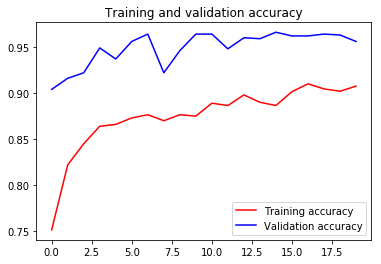

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()